In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.insert(0, '../scripts')
from simulation import *

In [6]:
N = 80000
p = 0.005
K = N*p
P = 16
tau = 0.01
dt = 1e-3
A = 2
theta = 0
sigma = 0.1

In [7]:
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N))

In [8]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N, p, size=N)
ji = build_ji(k, N)

100%|██████████| 80000/80000 [01:58<00:00, 675.43it/s]


In [9]:
# Store pattern associations using the bilinear plasticity rule
plasticity = BilinearPlasticityRule()
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K, p=1)

100%|██████████| 80000/80000 [00:05<00:00, 13762.89it/s]


In [54]:
# Adjust subpopulation weights
data_p1_copy = np.asarray(data_p1).copy()
data_p0_copy = np.asarray(data_p0).copy()
reweight(indptr, indices, data_p1_copy, # Asymmetric
         A, N, w_11=1, w_12=1, w_21=0, w_22=0) # 1, 1, 0, 0
reweight(indptr, indices, data_p0_copy, # Symmetric
         A, N, w_11=0, w_12=0, w_21=1, w_22=1) # 0, 0, 1, 1
data = data_p1_copy + data_p0_copy
W = cp.sparse.csr_matrix(
    (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
    shape=(N,N),
    dtype=cp.float32)

80000it [00:00, 131514.84it/s]
80000it [00:00, 125788.96it/s]


In [55]:
# Sanity check: visualize a single sample run 
r = simulate(
    T=1.0,
    dt=1e-3,
    tau=0.01,
    N=N,
    I_ext_1=-0.6,
    I_ext_2=-0.2,
    theta=theta,
    sigma=sigma,
    patterns=patterns,
    W=W)
q, q1, q2 = correlations(r, patterns, individual=True)

100%|██████████| 999/999 [00:02<00:00, 462.29it/s]


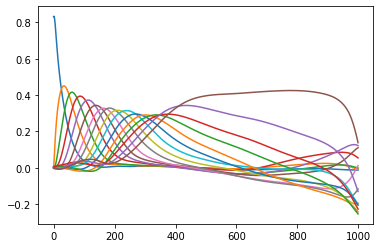

In [56]:
import matplotlib.pyplot as plt
for m in q:
    plt.plot(m);

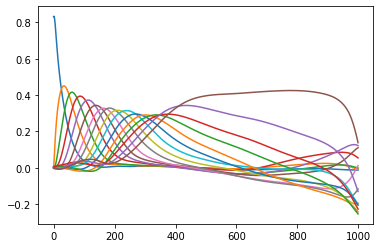

In [47]:
import matplotlib.pyplot as plt
for m in q:
    plt.plot(m);

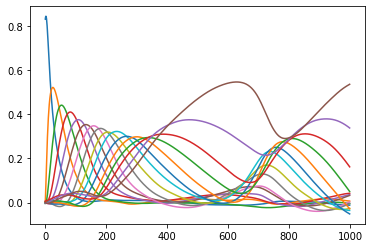

In [50]:
import matplotlib.pyplot as plt
for m in q:
    plt.plot(m);

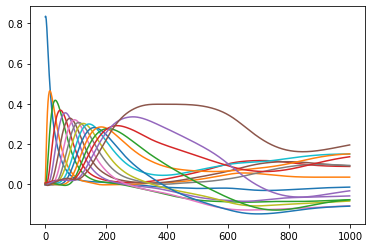

In [53]:
import matplotlib.pyplot as plt
for m in q:
    plt.plot(m);

#### Phase diagram

In [ ]:
I_ext_1=np.linspace(-1,0.,33)
I_ext_2=np.linspace(-1,0.,33)

params = {
    "N": N,
    "p": p,
    "K": K,
    "P": P,
    "A": A,
    "tau": tau,
    "theta": theta,
    "sigma": sigma,
}

combinations = list(itertools.product(
    np.atleast_1d(I_ext_1),
    np.atleast_1d(I_ext_2)))

directory = "2-bilinear-single-params/data/"

try:
    os.makedirs(directory)
except FileExistsError:
    pass

for args in tqdm(combinations[:]):
    params["I_ext_1"] = I_ext_1 = args[0]
    params["I_ext_2"] = I_ext_2 = args[1]
    r = simulate(
        1.,   # T
        1e-3, # dt
        tau,
        N,
        I_ext_1,
        I_ext_2,
        theta,
        sigma,
        patterns,
        W,
        disable_pbar=True)
    q, _, _ = correlations(r, patterns, individual=True)
    filename = "Iext1%.6f_Iext2%.6f"%(I_ext_1,I_ext_2) + ".npy"
    filepath = directory + filename
    np.save(open(filepath, 'wb'), {
        "q": q,
        "q1": q1,
        "q2": q2,
        "params": params})

 45%|████▌     | 491/1089 [1:43:01<2:04:36, 12.50s/it]

#### Single parameters

In [17]:
I_ext_1 = np.linspace(-1,0.,33)[[30,12]]
I_ext_2 = np.linspace(-1,0.,33)[[6,24]]

params = {
    "N": N,
    "p": p,
    "K": K,
    "P": P,
    "A": A,
    "tau": tau,
    "theta": theta,
    "sigma": sigma,
}

combinations = list(zip(
    np.atleast_1d(I_ext_1),
    np.atleast_1d(I_ext_2)))

directory = "2-bilinear-phase-diagram/data/single-params/"

try:
    os.makedirs(directory)
except FileExistsError:
    pass

for args in tqdm(combinations[:]):
    params["I_ext_1"] = I_ext_1 = args[0]
    params["I_ext_2"] = I_ext_2 = args[1]
    r = simulate(
        1.,   # T
        1e-3, # dt
        tau,
        N,
        I_ext_1,
        I_ext_2,
        theta,
        sigma,
        patterns,
        W,
        disable_pbar=True)
    q, q1, q2 = correlations(r, patterns, individual=True)
    filename = "Iext1%.6f_Iext2%.6f"%(I_ext_1,I_ext_2) + ".npy"
    filepath = directory + filename
    np.save(open(filepath, 'wb'), {
        "r": r,
        "q": q,
        "q1": q1,
        "q2": q2,
        "params": params})

100%|██████████| 2/2 [00:39<00:00, 19.95s/it]
